In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Load the SVHN dataset
train_dataset = SVHN(root="/content/drive/MyDrive/Deep Learning/CNN/dataset", split='train', download=True, transform=transform)
test_dataset = SVHN(root="/content/drive/MyDrive/Deep Learning/CNN/dataset", split='test', download=True, transform=transform)

Using downloaded and verified file: /content/drive/MyDrive/Deep Learning/CNN/dataset/train_32x32.mat
Using downloaded and verified file: /content/drive/MyDrive/Deep Learning/CNN/dataset/test_32x32.mat


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Inspect the dataset
print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Get a batch of training data
images, labels = next(iter(train_loader))
print(f'Batch of images shape: {images.shape}')
print(f'Batch of labels shape: {labels.shape}')


Training dataset size: 73257
Test dataset size: 26032
Batch of images shape: torch.Size([64, 3, 32, 32])
Batch of labels shape: torch.Size([64])


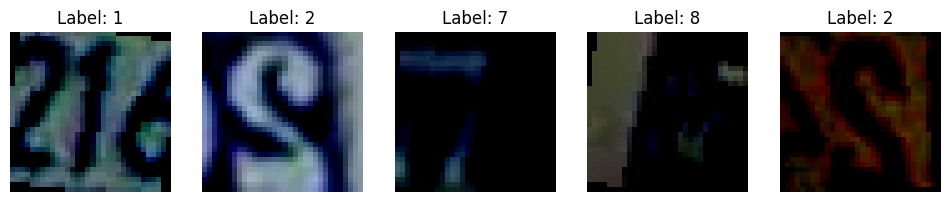

In [ ]:
# Function to show a batch of images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 12))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))
show_images(images[:5], labels[:5])

In [ ]:
# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier to fit the number of classes in the SVHN dataset (10 classes)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)


In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Enable mixed precision training if supported
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with mixed precision and detailed logging
# Training loop with batch logging
def train(model, train_loader, criterion, optimizer, device, epochs, log_interval=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            # Print batch loss every `log_interval` batches
            if batch_idx % log_interval == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


In [ ]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    accuracy = correct / total
    return accuracy, all_labels, all_preds


In [ ]:
# Train the model
train(model, train_loader, criterion, optimizer, device, epochs = 5)


In [ ]:
# Evaluate the model
accuracy, cm = evaluate(model, test_loader, device)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(cm)

In [ ]:
# Evaluate the model
accuracy, all_labels, all_preds = evaluate(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()